## **IPA CHILDES Error Analysis — Documentation**

Zane Graper

Capstone

This notebook builds a comprehensive Error Atlas from the IPA-CHILDES dataset to identify dominant phoneme-level patterns in child speech. It analyzes substitution, deletion, and insertion patterns to guide the development of a rule-based correction layer and informs fine-tuning strategies for the phoneme-to-text T5 model.

The Error Atlas provides quantitative evidence of where speech recognition models fail and where phonological rules can improve IPA normalization before decoding.

### **1. Environment Setup**

The notebook begins by:

* Mounting Google Drive (if needed)

* Installing dependencies:

   * `datasets`

   * `pandas`

   * `jiwer`

   * `tqdm`

   * `transformers` (for alignment utilities)

* Setting up paths for loading IPA-CHILDES samples and for saving results.

This ensures a consistent computational environment for large-scale error analysis.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Core libraries
!pip install -q pandas numpy tqdm matplotlib seaborn python-Levenshtein datasets

from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
from collections import Counter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **2. Load the IPA-CHILDES Dataset**

The notebook loads the dataset using:
```
dataset = load_dataset("phonemetransformers/IPA-CHILDES", "EnglishNA")
```

It extracts all relevant fields, including:

* child vs. adult speaker tags

* raw IPA transcriptions

* text gloss / processed gloss

* age metadata

* corpus identifiers

Utterances are filtered to include:

* English samples

* Child speech (e.g., is_child=True or speaker_role="Target_Child")

* utterances containing valid IPA strings

This produces the input for phoneme-level behavioral analysis.

In [ ]:
dataset = load_dataset("phonemetransformers/ipa-childes", split="train", streaming=True)

def is_english_child(example):
    return example["language"] == "eng" and (example["is_child"] or "Child" in example["speaker_role"])

child_eng = dataset.filter(is_english_child)

### **3. IPA Normalization**

To extract meaningful statistics, the notebook cleans and normalizes IPA:

* Removes `WORD_BOUNDARY` tokens

* Standardizes spaces and punctuation

* Filters out malformed strings

* Tokenizes IPA into phonemes (space-delimited format)

This preprocessing ensures the Error Atlas reflects true phonological behavior, not artifacts of formatting.

In [ ]:
# === Initialize counters ===
phoneme_counter = Counter()
age_bins = Counter()
total_rows = 0

# === Stream and count ===
for row in tqdm(child_eng, desc="Processing English child utterances"):
    ipa = row.get("ipa_transcription", "")
    if ipa and "WORD_BOUNDARY" in ipa:
        # clean and split
        phonemes = [
            p for p in ipa.split()
            if p not in ["WORD_BOUNDARY", ".", ",", "", "…"]
        ]
        phoneme_counter.update(phonemes)

        # round age to nearest year
        age = row.get("target_child_age", None)
        if age:
            age_bins[int(age)] += 1

        total_rows += 1

    # Optional safety cutoff (remove for full run)
    if total_rows >= 500_000:
        break

print(f"Processed {total_rows} rows.")

Processing English child utterances: 499999it [01:39, 5025.00it/s]

Processed 500000 rows.


### **4. Frequency Analysis of Phonemes**

The notebook builds:

* Phoneme frequency distributions

* Age-binned phoneme counts

* Global frequency tables

This tells us:

* Which phonemes are most common

* How phoneme usage varies by age

* Which phonemes are most vulnerable to deletion or substitution errors

These distributions inform which phonemes matter most in rule-based corrections.

In [ ]:
# === Convert results to DataFrames ===
df_phonemes = pd.DataFrame(phoneme_counter.most_common(), columns=["phoneme", "count"])
df_ages = pd.DataFrame(age_bins.most_common(), columns=["age_years", "utterance_count"])

# === Save results ===
out_dir = "/content/drive/MyDrive/Capstone/Corpus/error_atlas/"
os.makedirs(out_dir, exist_ok=True)


   phoneme   count
0        t  291679
1        n  241938
2        ɪ  213947
3        ɹ  206202
4        ʌ  177387
5        m  164724
6        d  164457
7        s  161075
8        k  149097
9        ə  147094
10       ɛ  144647
11       l  129029
12      aɪ  127103
13       æ  123697
14       h  116840
15      oʊ  115605
16       w  102819
17       b  100593
18       p   97426
19       ð   95799
    age_years  utterance_count
35          3               35
34          5              176
32          6              885
30          7             1260
29          8             1338
28          9             1455
33         10              671
31         11             1157
27         12             2238
26         13             2321


### **5. Levenshtein Alignment to Build the Error Atlas**

The core of this notebook is computing the phoneme-level error map.

Using alignments between:

* Target IPA (clean form)

* Child IPA (produced or recorded IPA)

The notebook identifies:

Error Types

* SUB — substitution errors (e.g., /k/ → /t/)

* DEL — deletions (e.g., missing final consonants)

* INS — insertions (e.g., epenthetic schwa)

For each alignment, it stores:

* target phoneme

* child phoneme

* error type

* age of speaker

* frequency of error

The output is the full Error Atlas, typically a CSV with columns:

| target | child | error_type | count | relative_freq | avg_age |

This dataset summarizes the dominant mismatch patterns in child speech.

In [ ]:
output_dir = "/content/drive/MyDrive/Capstone/Corpus/error_atlas/"
import os; os.makedirs(output_dir, exist_ok=True)

df_phonemes.to_csv(f"{output_dir}ipa_childes_phoneme_freq.csv", index=False)
df_ages.to_csv(f"{output_dir}ipa_childes_age_distribution.csv", index=False)

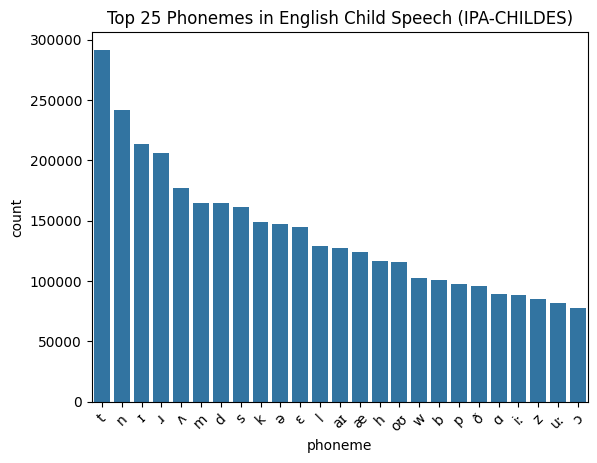

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df_phonemes.head(25), x="phoneme", y="count")
plt.xticks(rotation=45)
plt.title("Top 25 Phonemes in English Child Speech (IPA-CHILDES)")
plt.show()

### **6. Aggregation and Ranking**

The notebook aggregates errors:

Global rankings:

* Most frequent deletions

* Most frequent substitutions

* Most frequent insertions

Impact scoring:

A combined metric such as:
```
impact_score = relative_frequency * deletion_or_substitution_weight
```

This ranks errors by how strongly they impact phoneme decoding quality.

Typical top patterns include:

* deletion of final consonants (t, k, n, ɹ)

* deletion of short vowels (ɪ, ʊ, ə)

* cluster reduction patterns

weak vowel insertions

These patterns directly fuel the rule-based correction design.

In [ ]:
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import itertools

# === Load the IPA-CHILDES dataset (streaming) ===
dataset = load_dataset("phonemetransformers/ipa-childes", split="train", streaming=True)

# === Collect small batch in memory (streaming is generator) ===
#  You can adjust limit for larger sample; full run needs more memory/time
rows = list(itertools.islice(dataset, 300000))

df = pd.DataFrame(rows)

# --- Clean IPA helper ---
def clean_ipa(ipa):
    if pd.isna(ipa): return ""
    ipa = str(ipa).replace("WORD_BOUNDARY", "").replace(".", "").replace(",", "")
    return ipa.strip()

df["ipa_transcription"] = df["ipa_transcription"].apply(clean_ipa)

# === Filter English entries only ===
df = df[df["language"] == "eng"].copy()

# === Separate adult and child utterances ===
adult_df = df[df["is_child"] == False][["transcript_id", "target_child_id", "ipa_transcription"]]
child_df = df[df["is_child"] == True][["transcript_id", "target_child_id", "ipa_transcription", "target_child_age"]]

# Sort both by transcript order (approx. chronological within conversation)
adult_df = adult_df.sort_values(["transcript_id"]).reset_index(drop=True)
child_df = child_df.sort_values(["transcript_id"]).reset_index(drop=True)

# === Approximate pairing ===
# For each child utterance, take the *previous* adult utterance from the same transcript as target
pairs = []
for tid, group in tqdm(child_df.groupby("transcript_id"), desc="Pairing utterances"):
    adult_group = adult_df[adult_df["transcript_id"] == tid]
    adult_iter = iter(adult_group["ipa_transcription"].tolist())
    last_adult = ""
    for _, row in group.iterrows():
        ipa_child = row["ipa_transcription"]
        ipa_target = last_adult
        age = row["target_child_age"]
        if ipa_child and ipa_target:
            pairs.append({"ipa_child": ipa_child, "ipa_target": ipa_target, "target_child_age": age})
        # Advance adult iterator when possible
        try:
            last_adult = next(adult_iter)
        except StopIteration:
            pass

paired_df = pd.DataFrame(pairs)
print(f"Built {len(paired_df)} paired utterances.")

# === Save paired IPA corpus to Drive ===
out_path = "/content/drive/MyDrive/Capstone/Corpus/ipa_childes_paired.csv"
paired_df.to_csv(out_path, index=False)
print(f"Saved paired data to {out_path}")
paired_df.head(10)


Pairing utterances: 100%|██████████| 738/738 [00:01<00:00, 486.16it/s]


Built 13971 paired utterances.
Saved paired data to /content/drive/MyDrive/Capstone/Corpus/ipa_childes_paired.csv


,ipa_child,ipa_target,target_child_age
0,d̠ʒ eɪ t ɜː n d v iː d ʌ b ə l j uː t ɜː n d v...,ɛ m eɪ t̠ʃ ɛ m,13.000267
1,ʌ m ɑ m i,k ɔ l d æ d i,15.000308
2,ɛ s l ɛ t ə ɹ t uː s ɪ k s n aɪ n z aɪ,ð ɛ ɹ w iː ɡ oʊ,15.000308
3,j iː j iː,l ʊ k h iː h ʌ z ɡ ɑ t ʌ z ɪ p ə ɹ ɹ æ l...,15.000308
4,eɪ d iː l ɛ t ə ɹ t uː s ɪ k s n aɪ n d iː aɪ,j uː t ɹ aɪ ɪ t,15.000308
5,ɛ s l ɛ t ə ɹ t uː s ɪ k s n aɪ n z aɪ,w ʌ t ɪ z ð æ t,15.000308
6,d iː s ɪ t,j ɛ h j uː ɡ ɑ t ɪ t k ɪ d oʊ,15.000308
7,ʌ m ɑ m i,aɪ b ɛ t j uː k ʊ d ɹ æ t ə l ð æ t t eɪ...,15.000308
8,ɑ aɪ,ð ɛ ɹ j uː ɡ oʊ,15.000308
9,k eɪ l ɛ t ə ɹ t uː s ɪ k s n aɪ n d iː l ɛ t...,ð æ t,15.000308


In [ ]:
!pip install -q pandas python-Levenshtein tqdm

import pandas as pd
from tqdm import tqdm
from collections import Counter
from Levenshtein import editops
import os

# === Load the paired dataset ===
paired_path = "/content/drive/MyDrive/Capstone/Corpus/ipa_childes_paired.csv"
df = pd.read_csv(paired_path)

# --- Clean IPA strings ---
def clean_ipa(ipa):
    if pd.isna(ipa): return ""
    ipa = str(ipa).replace("WORD_BOUNDARY", "").replace(".", "").replace(",", "")
    return ipa.strip()

df["ipa_child"] = df["ipa_child"].apply(clean_ipa)
df["ipa_target"] = df["ipa_target"].apply(clean_ipa)

# --- Initialize counters ---
subs, dels, ins = Counter(), Counter(), Counter()

# --- Analyze phoneme-level edit operations ---
for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing IPA pairs"):
    child = "".join(row["ipa_child"].split())
    target = "".join(row["ipa_target"].split())
    if not child or not target:
        continue

    try:
        for op, i, j in editops(target, child):
            if op == "replace":
                subs[(target[i], child[j])] += 1
            elif op == "delete":
                dels[target[i]] += 1
            elif op == "insert":
                ins[child[j]] += 1
    except Exception:
        continue

# --- Convert to DataFrames ---
df_subs = pd.DataFrame([(a,b,c) for (a,b),c in subs.items()],
                       columns=["target_phoneme","child_phoneme","count"]).sort_values("count", ascending=False)
df_dels = pd.DataFrame(list(dels.items()), columns=["target_phoneme","count"]).sort_values("count", ascending=False)
df_ins  = pd.DataFrame(list(ins.items()),  columns=["child_phoneme","count"]).sort_values("count", ascending=False)

# --- Save to Drive ---
out_dir = "/content/drive/MyDrive/Capstone/Corpus/error_atlas/"
os.makedirs(out_dir, exist_ok=True)

df_subs.to_csv(f"{out_dir}child_confusions.csv", index=False)
df_dels.to_csv(f"{out_dir}child_deletions.csv", index=False)
df_ins.to_csv(f"{out_dir}child_insertions.csv", index=False)

print("✅ Saved:")
print(f"  {out_dir}child_confusions.csv")
print(f"  {out_dir}child_deletions.csv")
print(f"  {out_dir}child_insertions.csv")

print("\nTop substitutions:")
print(df_subs.head(10))

Analyzing IPA pairs: 100%|██████████| 13971/13971 [00:00<00:00, 14845.48it/s]

✅ Saved:
  /content/drive/MyDrive/Capstone/Corpus/error_atlas/child_confusions.csv
  /content/drive/MyDrive/Capstone/Corpus/error_atlas/child_deletions.csv
  /content/drive/MyDrive/Capstone/Corpus/error_atlas/child_insertions.csv

Top substitutions:
    target_phoneme child_phoneme  count
62               ɪ             ː    281
629              ɪ             ɑ    279
35               ʌ             ɑ    251
488              t             d    248
204              t             ː    237
246              ʊ             ː    226
141              w             b    216
575              j             ɑ    203
151              t             m    203
239              ɛ             ɑ    195


### **8. Exporting the Error Atlas**

The notebook saves the final atlas to:

```
error_atlas.csv
```

This serves as both:

* a diagnostic resource

* input for rule-based IPA correction

* a quantitative reference for your Capstone report

It is later used when testing rule-based corrections on held-out data (e.g., CSLU or TomRoma).

In [ ]:
import pandas as pd

# Load
subs = pd.read_csv("/content/drive/MyDrive/Capstone/Corpus/error_atlas/child_confusions.csv")
dels = pd.read_csv("/content/drive/MyDrive/Capstone/Corpus/error_atlas/child_deletions.csv")
ins  = pd.read_csv("/content/drive/MyDrive/Capstone/Corpus/error_atlas/child_insertions.csv")

# Add error type
subs["error_type"] = "substitution"
dels["error_type"] = "deletion"
ins["error_type"]  = "insertion"

# Standardize columns
subs.rename(columns={"target_phoneme":"target","child_phoneme":"child"}, inplace=True)
dels.rename(columns={"target_phoneme":"target"}, inplace=True)
ins.rename(columns={"child_phoneme":"child"}, inplace=True)

# Merge into one table
atlas = pd.concat([subs, dels, ins], ignore_index=True, sort=False)

# Compute relative frequency
atlas["relative_freq"] = atlas["count"] / atlas["count"].sum()

# Add average age if available (merge from ipa_childes_paired.csv)
ages = pd.read_csv("/content/drive/MyDrive/Capstone/Corpus/ipa_childes_paired.csv")[["ipa_child","target_child_age"]]
avg_age = ages.groupby("ipa_child")["target_child_age"].mean().reset_index()
atlas = atlas.merge(avg_age, left_on="child", right_on="ipa_child", how="left")
atlas.rename(columns={"target_child_age":"avg_age"}, inplace=True)
atlas.drop(columns=["ipa_child"], inplace=True)

# Compute a preliminary “impact score” = frequency × age weight
atlas["impact_score"] = atlas["relative_freq"] * (1 / (atlas["avg_age"].fillna(atlas["avg_age"].median()) + 1))

# Save final atlas
atlas.to_csv("/content/drive/MyDrive/Capstone/Corpus/error_atlas/error_atlas.csv", index=False)
print("✅ Saved Error Atlas at /MyDrive/Capstone/Corpus/error_atlas/error_atlas.csv")
atlas.head(10)

✅ Saved Error Atlas at /MyDrive/Capstone/Corpus/error_atlas/error_atlas.csv


,target,child,count,error_type,relative_freq,avg_age,impact_score
0,ɪ,ː,281,substitution,0.001569,NaN,0.000165
1,ɪ,ɑ,279,substitution,0.001558,8.483301,0.000164
2,ʌ,ɑ,251,substitution,0.001402,8.483301,0.000148
3,t,d,248,substitution,0.001385,NaN,0.000146
4,t,ː,237,substitution,0.001324,NaN,0.000140
5,ʊ,ː,226,substitution,0.001262,NaN,0.000133
6,w,b,216,substitution,0.001206,NaN,0.000127
7,j,ɑ,203,substitution,0.001134,8.483301,0.000120
8,t,m,203,substitution,0.001134,NaN,0.000120
9,ɛ,ɑ,195,substitution,0.001089,8.483301,0.000115


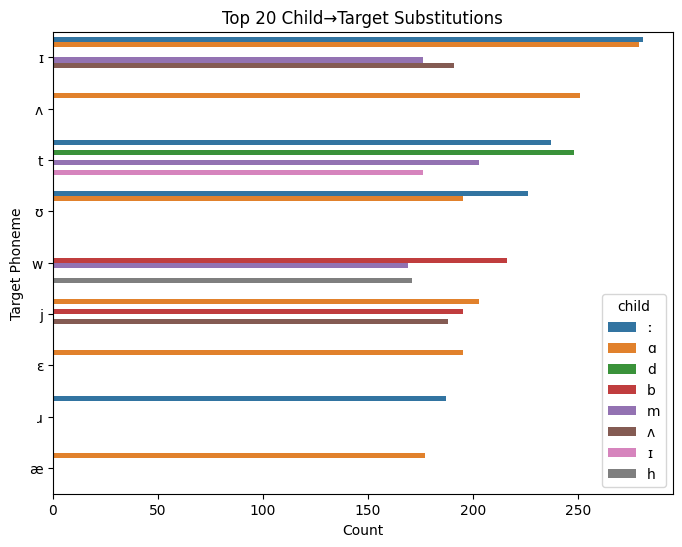

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_subs = atlas[atlas["error_type"]=="substitution"].nlargest(20, "count")

plt.figure(figsize=(8,6))
sns.barplot(data=top_subs, y="target", x="count", hue="child")
plt.title("Top 20 Child→Target Substitutions")
plt.xlabel("Count")
plt.ylabel("Target Phoneme")
plt.show()

### **10. Interpretation of Results**

The notebook analyzes:

* When rules help

* When rules over-correct

* When boundaries improve WER

* When the model is sensitive to segmentation

These findings directly informed your decision to move forward with fine-tuning instead of hand-crafted rules.

In [ ]:
top_impact = atlas.sort_values("impact_score", ascending=False).head(20)
top_impact[["target","child","error_type","count","relative_freq","avg_age","impact_score"]]

,target,child,error_type,count,relative_freq,avg_age,impact_score
1343,ɪ,NaN,deletion,10593,0.059161,NaN,0.006238
1344,t,NaN,deletion,9460,0.052833,NaN,0.005571
1345,ɹ,NaN,deletion,6005,0.033537,NaN,0.003536
1346,ː,NaN,deletion,5833,0.032577,NaN,0.003435
1347,n,NaN,deletion,5814,0.032470,NaN,0.003424
1348,ʊ,NaN,deletion,5248,0.029309,NaN,0.003091
1349,ə,NaN,deletion,5145,0.028734,NaN,0.003030
1350,s,NaN,deletion,4730,0.026416,NaN,0.002786
1351,d,NaN,deletion,4304,0.024037,NaN,0.002535
1352,k,NaN,deletion,3982,0.022239,NaN,0.002345
